# Preprocess data

Aims:
- Write the probe information from the two datasets
- Save the formatted data matrix (GEP and methylation)

In [1]:
suppressMessages({
    library(hashmap)
    library(tidyverse)
    library(mygene)
    library(cowplot)
    library(magrittr)
})
trim.trailing <- function (x) sub("\\s+$", "", x)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

In [2]:
# load RNAseq and methylation data
gep <- read_tsv('../../data/Figueroa/matcheddata/GEP-filtered.tsv')
methylation <- read_tsv('../../data/Figueroa/matcheddata/methylation-filtered.tsv')

Parsed with column specification:
cols(
  .default = col_double(),
  Name = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  Gene = col_character(),
  Name = col_character()
)
See spec(...) for full column specifications.


## Preprocess Expression Array
- `data/Figueroa/processeddata/gep-name2desc.tsv`: probe ID, corresponding gene and description
- `data/Figueroa/processeddata/gep-transcription-related.tsv`: the expression matrix of probes that is related to transcription and methylation
- `data/Figueroa/processeddata/genes-transcription-related.tsv`: GO BP ontology of the genes related to transcription and methylation

In [3]:
gep.mat <- data.matrix(gep[,-seq(2)])
colnames(gep.mat) <- colnames(gep)[-seq(2)]
rownames(gep.mat) <- gep$Name 
head(gep.mat, n=2) # not normalized 
dim(gep.mat)

,GSM464771,GSM464772,GSM464773,GSM464774,GSM464775,GSM464776,GSM464777,GSM464778,GSM464779,GSM464780,⋯,GSM465020,GSM465024,GSM465026,GSM465030,GSM465060,GSM465061,GSM465062,GSM465063,GSM465064,GSM465065
10000_at,74.3174,27.66245,102.0721,101.6374,31.43173,74.90709,68.8868,114.4036,98.7125,103.8562,⋯,106.8033,207.4528,120.7066,84.64849,139.1024,43.22202,236.6838,210.1270,220.1624,147.4783
10001_at,660.5697,536.18860,314.0691,856.6095,708.81936,433.50528,528.4353,448.2595,543.2180,707.8009,⋯,406.9814,586.1430,410.5169,486.99356,547.8272,587.26037,549.8494,398.5402,457.6389,384.2906


[1] 17788   344

In [4]:
name=gep[,seq(1)]
gene=sapply(as.vector(gep$Description), function(x) trim.trailing(strsplit(x, ' - ')[[1]][1]))
desc=sapply(as.vector(gep$Description), function(x) trim.trailing(strsplit(x, ' - ')[[1]][2]))

write.table(data.frame(name=name, gene=gene, desc=desc), file='../../data/Figueroa/processeddata/gep-name2desc.tsv', sep='\t', col.names=T, row.names=F, quote=F)

In [5]:
annotations <- queryMany(gene, scopes='symbol', fields=c('go'), species='human', returnall=T)

terms <- c()
for (i in seq(length(annotations$response$query))) {
  if (is.na(annotations$response$notfound[i])) {
    query <- annotations$response$query[i]
    termConcat <- paste(as.character(annotations$response$go.BP[[i]]$term), collapse=', ')
    terms <- rbind(terms, c(query, termConcat))
  }
}

Querying chunk 1
Querying chunk 2
Querying chunk 3
Querying chunk 4
Querying chunk 5
Querying chunk 6
Querying chunk 7
Querying chunk 8
Querying chunk 9
Querying chunk 10
Querying chunk 11
Querying chunk 12
Querying chunk 13
Querying chunk 14
Querying chunk 15
Querying chunk 16
Querying chunk 17
Querying chunk 18


Finished


In [6]:
head(terms[terms[,1]=='DNMT3B',] ) # a methyltransferase

[1] "DNMT3B"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
[2] "negative regulation of transcription by RNA polymerase II, response to hypoxia, DNA methylation, DNA methylation, response to toxic substance, response to ionizing radiation, positive regulation of gene expression, response to activity, response to caffeine, response to estradiol, response to vitamin A, response to cocaine, positive regulation of neuron differentiation, negative regulation of gene expression, epigenetic, positive regulation of histone H3-K4 methylation, negative regulation of histone H3-K9 methylation, cellular response to hyperoxia, cellular response to dexamethasone stimulus, C-5 methylation of cytosine"

In [7]:
terms.cleaned <- data.frame(name=terms[,1], annotation=terms[,2]) %>%
  group_by(name) %>%
  mutate(annotations = paste0(annotation, collapse = ", ")) %>%
  dplyr::select(-annotation) %>%
  distinct()
terms.filtered <- terms.cleaned %>%
  dplyr::filter(grepl('methyl|transcrip', annotations)) # 3417 left
dim(terms.filtered)

[1] 3417    2

In [8]:
write.table(terms.filtered, file='../../data/Figueroa/processeddata/genes-transcription-related.tsv',
           sep='\t', row.names=F, col.names=T, quote=F)

In [9]:
filtered.idx <- which(gene %in% terms.filtered$name)
gep.filtered <- gep.mat[filtered.idx,]
rownames(gep.filtered) <- gene[filtered.idx]

In [10]:
dim(gep.filtered)

[1] 3417  344

In [11]:
write.table(gep.filtered, file='../../data/Figueroa/processeddata/gep-transcription-related.tsv', sep='\t', row.names=T, col.names=T, quote=F)

## Preprocess Methylation Array

- `data/Figueroa/processeddata/methylation-matrix.tsv`: methylation matrix on all probes that with a gene label
- `data/Figueroa/processeddata/methylation-annotation.tsv`: probe ID, name and short description

In [12]:
methylation.filtered <- methylation %>%
  gather(patient, value, -c(Gene, Name)) %>%
  group_by(Gene, Name) %>%
  summarize(sd = sd(value)) %>%
  left_join(methylation) %>%
  mutate(gene=sapply(Name, function(x) trim.trailing(strsplit(x, ' - ')[[1]][1]))) %>%
  mutate(name=sapply(Name, function(x) trim.trailing(strsplit(x, ' - ')[[1]][2]))) %>% 
  filter(gene != 'NA') %>%
  dplyr::select(-c(sd, Name))

Joining, by = c("Gene", "Name")


In [13]:
dim(methylation.filtered)

[1] 22759   347

In [14]:
methyl.mat <- data.matrix(methylation.filtered[,-c(1, 346, 347)])
rownames(methyl.mat) <- methylation.filtered$gene
head(methyl.mat, n=2)

,GSM464771,GSM464772,GSM464773,GSM464774,GSM464775,GSM464776,GSM464777,GSM464778,GSM464779,GSM464780,⋯,GSM465020,GSM465024,GSM465026,GSM465030,GSM465060,GSM465061,GSM465062,GSM465063,GSM465064,GSM465065
LOC100133331,-2.789846,-3.999583,-2.598931,-2.958554,-4.679239,-3.435181,-3.997497,-3.09188,-3.801078,-3.799687,⋯,-3.017813,-3.176045,-3.263981,-2.793057,-3.048723,-0.8478957,-3.882048,-3.607409,-3.011330,-3.394784
AK091100,-2.344868,-2.540436,-1.988755,-3.795202,-3.904373,-2.776700,-3.025187,-2.88055,-3.461039,-2.904604,⋯,-2.935405,-2.799225,-2.294494,-2.910663,-2.991778,-1.5180257,-3.513794,-3.325757,-3.168259,-3.012504


In [15]:
write.table(methylation.filtered[,c(1, 346, 347)], file='../../data/Figueroa/processeddata/methylation-annotation.tsv',
           sep='\t', row.names=F, col.names=T, quote=F)
write.table(methyl.mat, file='../../data/Figueroa/processeddata/methylation-matrix.tsv',
           sep='\t', row.names=T, col.names=T, quote=F)

In [41]:
dim(methyl.mat)

[1] 22759   344

## Normalization across patients

In [44]:
methyl.mat.zscore = t(apply(methyl.mat, 1, scale))

In [45]:
dim(methyl.mat.zscore)

[1] 22759   344

In [46]:
colnames(methyl.mat.zscore) = colnames(methyl.mat)

In [47]:
methyl.mat.zscore %<>% data.frame

In [48]:
methyl.mat.zscore$probe = methylation.filtered$gene

In [49]:
write.table(methyl.mat.zscore, file='../../data/Figueroa/processeddata/methyl-zscore.tsv', sep='\t', row.names=F, col.names=T, quote=F)

## Distribution of mean and variance of methylation probes across patients
- `data/Figueroa/methyl-successiveNormalized.tsv`: methylation array that is successively normalized

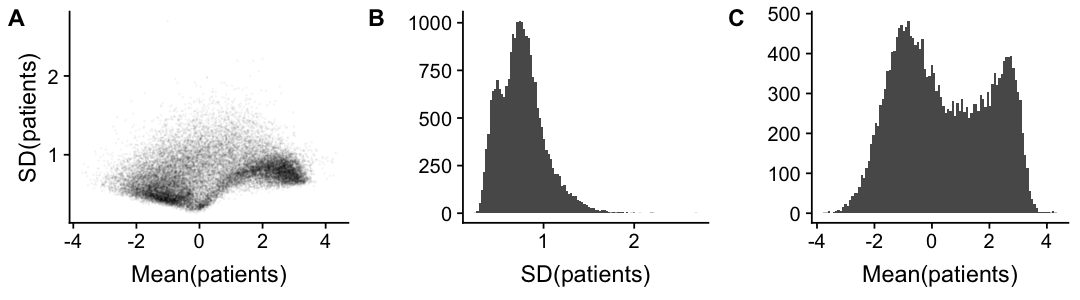

In [22]:
options(repr.plot.height=2.5, repr.plot.width=9)
sd.mat <- apply(methyl.mat, 1, sd)
mean.mat <- apply(methyl.mat, 1, mean)
p1 <- ggplot(data=data.frame(mean=mean.mat, sd=sd.mat)) +
  geom_point(aes(x=mean, y=sd), alpha=0.03, color='black', size=0.1) + xlab('Mean(patients)') + ylab('SD(patients)')
p2 <- qplot(sd.mat, geom='histogram', bins=100, xlab='SD(patients)') 
p3 <- qplot(mean.mat, geom='histogram', bins=100, xlab='Mean(patients)')
p.all <- plot_grid(p1, p2, p3, labels=LETTERS[1:3], ncol=3) # probes with overall positive expression tends to have larger variance as magnitude of mean gets larger
                              # for probes with overall negative expression
p.all

In [23]:
ggsave(p.all, file='../../figures/Figueroa/methyl-distn.pdf', width=9, height=2.5)

Normalize across patients to make the probes comparable before applying phenograph

In [37]:
X <- methyl.mat
f.diff = c()
while (TRUE) {
    X.prev <- X
    X <- t(apply(X, 1, scale))
    X <- apply(X, 2, scale)
  
    F.diff <- norm(X, type='F') - norm(X.prev, type='F') # compute the Frobenius norm difference between two matrices
    print(F.diff)
    f.diff <- c(f.diff, F.diff)
    if (abs(F.diff) < 1e-8) break
}

[1] -2424.767
[1] -9.41327e-11


In [38]:
# save the succesively normalized array to file
colnames(X) <-  colnames(methyl.mat)
probe <- methylation.filtered$gene
X <- data.frame(X)
X <- cbind(probe, X)

In [39]:
head(X, n=2)

probe,GSM464771,GSM464772,GSM464773,GSM464774,GSM464775,GSM464776,GSM464777,GSM464778,GSM464779,⋯,GSM465020,GSM465024,GSM465026,GSM465030,GSM465060,GSM465061,GSM465062,GSM465063,GSM465064,GSM465065
LOC100133331,0.5656646,-0.2762509,0.5464723,1.390992,-1.250427,-0.7231627,-1.3639633,-0.6217651,-0.09007192,⋯,-0.2577998,0.4027578,-0.64940248,-0.430032,0.2672083,2.583242,-0.0507937,-0.6815596,1.8492071,0.3190695
AK091100,0.8362348,0.9454242,1.0655506,-1.012361,-1.288259,-0.3199215,-0.3368407,-0.9481995,-0.63231572,⋯,-0.9804344,0.3609546,0.09337669,-1.229339,-0.4294562,1.591340,-0.4957257,-1.2191908,0.7066319,0.1522136


In [40]:
write.table(X, file='../../data/Figueroa/processeddata/methyl-successiveNormalized.tsv', sep='\t', row.names=F, col.names=T, quote=F)